## MDI230 : Queueing theory - Modèles épidémiologiques

### Simulation épidémie

#### Rémi Jaylet, Augustin Laboulet, Romain Louvet

### Imports

In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
import pandas as pd

### Definition des paramètres

On cherche ici à modéliser une épidémie, en suivant le cours on utilise les notations suivantes :

$N$ : la taille de la population

$S(t)$ : le nombre d'individus susceptibles d'être contaminés
($s(t)$ en pourcentage)

$I(t)$ : le nombre d'individus infectés
($i(t)$ en pourcentage)

$R(t)$ : les retirés, ceux qui ne sont plus contaminables soient parce qu'ils sont décédés, soient parce que guéris et immunisés
($r(t)$ en pourcentage)

$\beta$ : paramètre lois de Poisson pour un infecté de rencontré un invidu susceptible

$\gamma$ : le temps moyen d'infection

$R_0$ : le nombre moyen de personnes contaminées par jour en moyenne.
Rq : $R_0 = \beta/\gamma$ 

## Résolution du système déterministe SIR

Grace aux paramètres définis prédécemment, on peut définir le modèle SIR en considérant le système suivant : 

* $s(t) + i(t) + r(t) = 1$

* $s'(t) = -\beta s(t) i(t)$

* $i'(t) = -\gamma i(t) + \beta i(t) s(t)$

* $r'(t) = \gamma i(t)$

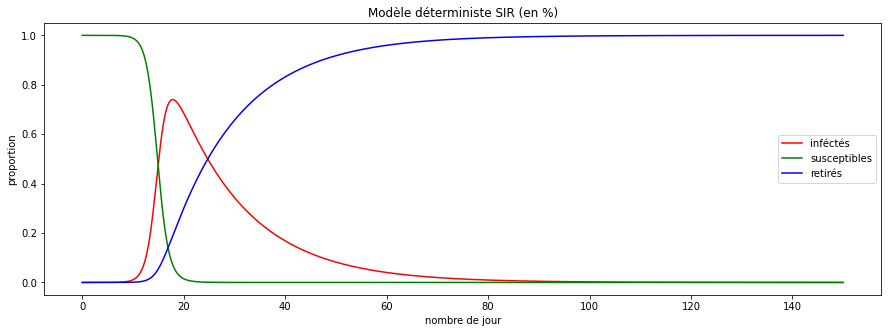

In [2]:
# Initialisation des paramètres du modèles
gamma = 1/14  #durée d'infection de 14 jours
beta = 1  # une rencontre par jour en moyenne 

# Conditions initiales
i0 = 0.000001  # une personne contaminée au départ sur une population de 1 millions de personnes
s0 = 1-i0  
r0 = 0

# Définition du système à résoudre
def equadiff(t, Y, gamma, beta):
    di = -gamma*Y[0] + beta*Y[0]*Y[1]
    ds = -beta*Y[0]*Y[1]
    dr = gamma*Y[0]
    return [di, ds, dr]

# Résolution des équations
sol = solve_ivp(equadiff, [0, 150], [i0, s0, r0], method='RK45', args=(gamma, beta), max_step=0.01)

fig = plt.figure(figsize=(15,5))
plt.plot(sol.t, sol.y[0], label="inféctés", color="red")
plt.plot(sol.t, sol.y[1], label="susceptibles", color="green")
plt.plot(sol.t, sol.y[2], label = "retirés", color="blue")
plt.legend()
plt.xlabel("nombre de jour")
plt.ylabel("proportion")
plt.title("Modèle déterministe SIR (en %)")
plt.show()

## Processus de Markov

On étudie le modèle suivant : 

On considère le processus de Markov $(S(t),I(t),R(t))$.

Loi de la durée d'infection : exp($\gamma$)

Loi de rencontre d'un individu : processus de Poisson d'intensité $\beta$

taux de guérisson : $i\gamma$ 

taux d'infection : $i\beta$



Pour avoir le même nombre de personnes que dans le modèle précédent on a $N = 1/i_0 - 1$

In [3]:
def markov(I0, S0, R0,t,gamma,beta): 
    
    # Initialisation des paramètres du modèles
    all_S,all_I,all_R = [S0],[I0],[R0]
    N = S0
    S,I,R = S0,I0,R0
    
    # Définition du temps
    times=[0]
    time=np.random.exponential(1/(I*gamma+beta*I*S/N))

    while time < t and I!=0 :
        r = np.random.rand()
        taux = I*gamma/(I*gamma+beta*I*S/N+1e-10)

        if taux > r :  # Individu guéri
            all_S.append(S)
            all_I.append(I-1)
            all_R.append(R+1)
            I=I-1
            R=R+1

        else :  # Individu infecté
            all_S.append(S-1)
            all_I.append(I+1)
            all_R.append(R)
            S=S-1
            I=I+1

        times.append(time)
        time += np.random.exponential(1/(I*gamma+beta*I*S/N+1e-10))

    return (times,all_S,all_I,all_R)

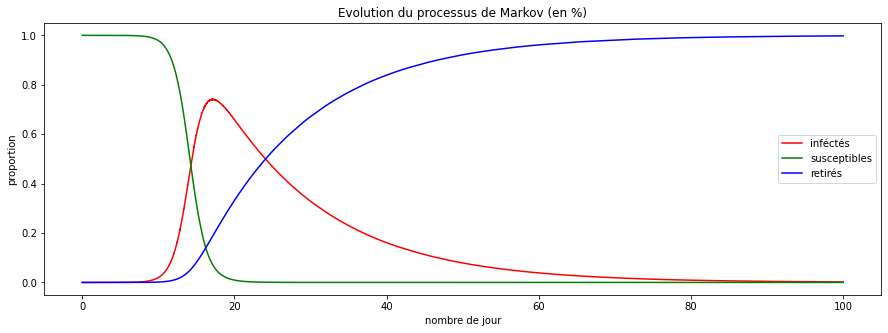

In [17]:
# Initialisation des paramètres du modèles
gamma = 1/14 #duree d'infection à 14 jours
beta = 1 #une rencontre par jour en moyenne 

# Définition des conditions initiales
N=int(1/i0)-1
S0,I0,R0 = N,1,0

times,S,I,R = markov(I0,S0,R0,100,gamma,beta)

#affichage des résultats 
fig = plt.figure(figsize=(15,5))
plt.plot(times, np.array(I)/(N+1), label="inféctés", color="red")
plt.plot(times, np.array(S)/(N+1), label="susceptibles", color="green")
plt.plot(times, np.array(R)/(N+1), label = "retirés", color="blue")
plt.title("Evolution du processus de Markov (en %)")
plt.xlabel("nombre de jour")
plt.ylabel("proportion")
plt.legend()
plt.show()

Les deux modèles précédents semblent obtenir les mêmes résultats, on a donc décidé d'utiliser le premie pour la suite.

## Etude des paramètres du modèle

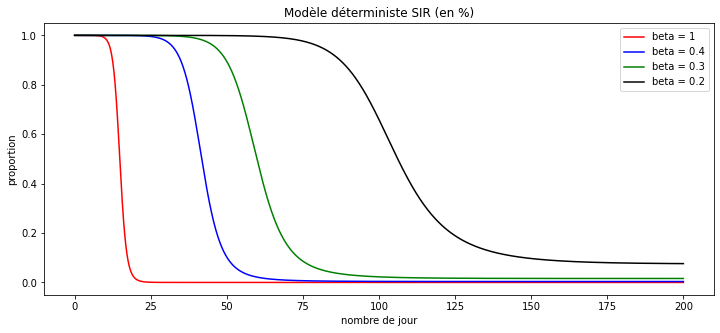

In [5]:
# Résolution des équations
sol1 = solve_ivp(equadiff, [0, 200], [i0, s0, r0], method='RK45', args=(1/14, 1), max_step=0.01)

sol2 = solve_ivp(equadiff, [0, 200], [i0, s0, r0], method='RK45', args=(1/14, 0.4), max_step=0.01)

sol3 = solve_ivp(equadiff, [0, 200], [i0, s0, r0], method='RK45', args=(1/14, 0.3), max_step=0.01)

sol4 = solve_ivp(equadiff, [0, 200], [i0, s0, r0], method='RK45', args=(1/14, 0.2), max_step=0.01)


fig = plt.figure(figsize=(12,5))
plt.plot(sol1.t, sol1.y[1], label="beta = 1", color="red")
plt.plot(sol2.t, sol2.y[1], label="beta = 0.4", color="blue")
plt.plot(sol3.t, sol3.y[1], label="beta = 0.3", color="green")
plt.plot(sol4.t, sol4.y[1], label="beta = 0.2", color="black")
plt.legend()
plt.title("Modèle déterministe SIR (en %)")
plt.xlabel("nombre de jour")
plt.ylabel("proportion")
plt.show()

Pour une durée d'infection de 14 jours on observe que pour $\beta < 0,3$ on toutes personnes ne seront pas contaminées

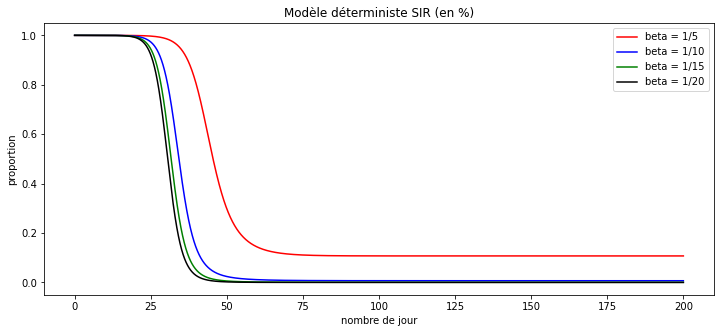

In [21]:
# Résolution des équations
sol1 = solve_ivp(equadiff, [0, 200], [i0, s0, r0], method='RK45', args=(
    1/5, 0.5), max_step=0.01)

sol2 = solve_ivp(equadiff, [0, 200], [i0, s0, r0], method='RK45', args=(
    1/10, 0.5), max_step=0.01)

sol3 = solve_ivp(equadiff, [0, 200], [i0, s0, r0], method='RK45', args=(
    1/15, 0.5), max_step=0.01)

sol4 = solve_ivp(equadiff, [0, 200], [i0, s0, r0], method='RK45', args=(
    1/20, 0.5), max_step=0.01)


fig = plt.figure(figsize=(12,5))
plt.plot(sol1.t, sol1.y[1], label="beta = 1/5", color="red")
plt.plot(sol2.t, sol2.y[1], label="beta = 1/10", color="blue")
plt.plot(sol3.t, sol3.y[1], label="beta = 1/15", color="green")
plt.plot(sol4.t, sol4.y[1], label="beta = 1/20", color="black")
plt.legend()
plt.title("Modèle déterministe SIR (en %)")
plt.xlabel("nombre de jour")
plt.ylabel("proportion")
plt.show()

Pour $\beta = 0,5$ on observe que pour $\gamma > 1/10 $ on toutes personnes ne seront pas contaminées, ce qui correspond à une durée d'infection inférieur ou égale à 10 jours 

## Convergence du processus de Markov

<Figure size 432x288 with 0 Axes>

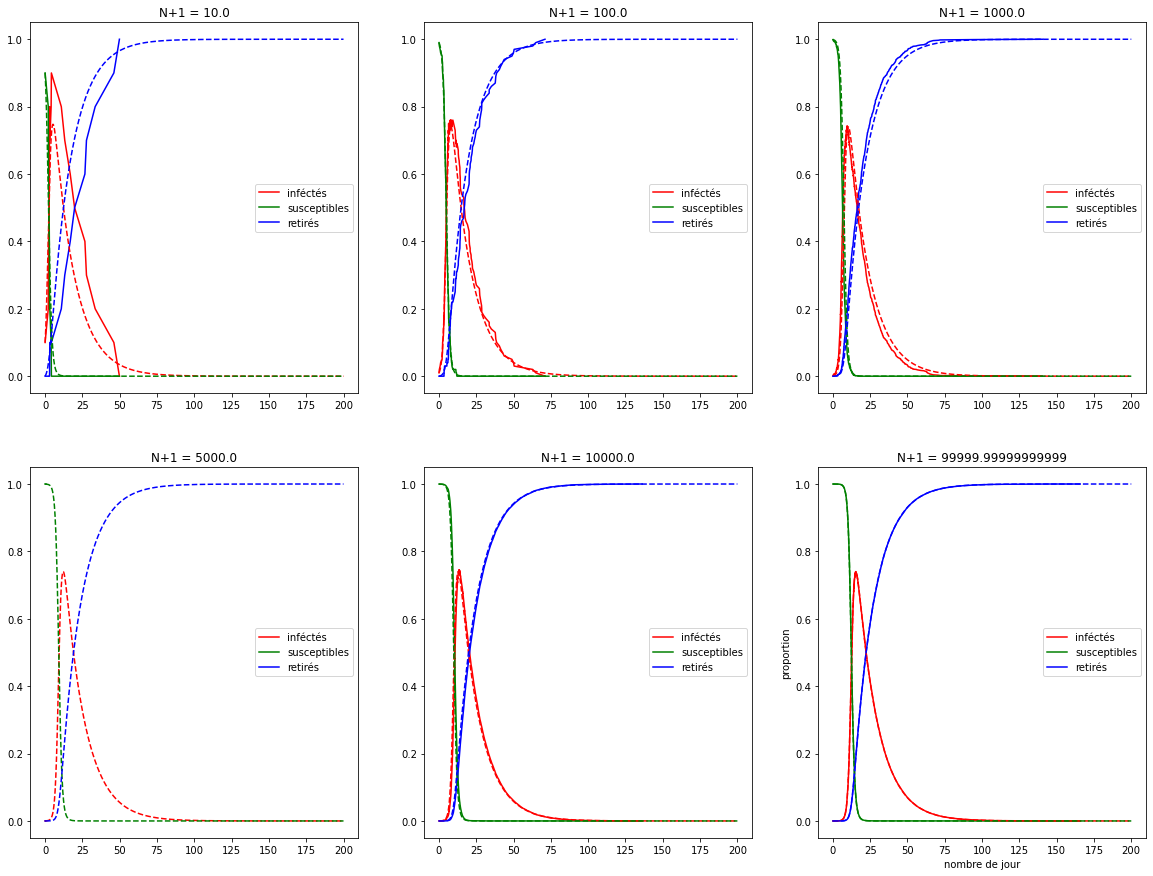

In [11]:
# Initialisation des paramètres du modèles : on reprend ceux par défaut comme auparavant
gamma = 1/14
beta = 1

i0_ = np.array([0.1, 0.01, 0.001, 0.0002, 0.0001, 0.00001])
s0_ = 1-i0_
r0 = 0

R0,I0,S0_ = 0,1,1/i0_-1 



fig = plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,15))
axes = axes.ravel()

for i in range(len(i0_)):
    solution = solve_ivp(equadiff, [0, 200], [i0_[i], s0_[i], r0], method='RK45',
                         args=(gamma, beta), max_step=0.01)
    times,S,I,R = markov(I0, S0_[i], R0, 200, gamma, beta)

    axes[i].plot(times, np.array(I)/(S0_[i]+1), label="inféctés", color="red")
    axes[i].plot(times, np.array(S)/(S0_[i]+1), label="susceptibles", color="green")
    axes[i].plot(times, np.array(R)/(S0_[i]+1), label = "retirés", color="blue")

    axes[i].plot(solution.t, solution.y[0], color="red", ls='--')
    axes[i].plot(solution.t, solution.y[1], color="green", ls='--')
    axes[i].plot(solution.t, solution.y[2], color="blue", ls='--')
    axes[i].legend()
    plt.xlabel("nombre de jour")
    plt.ylabel("proportion")
    axes[i].set_title("N+1 = " +str(1/i0_[i]))
    
plt.show()

On constate la converge du modèle a partir d'à peu près 5000 personnes.

## Question ouverte : estimation des paramètres sur un département 

On se place dans le cadre de la modélisation de la pandémie de la Covid-19.  Nous utilisons les données disponibles sur le lien fourni dans l'énoncé du sujet.

Pour cette question, nous nous focalisons sur le département de Paris, l'un des département les plus touché pendant la pandémie.

In [86]:
df = pd.read_csv('donnees-hospitalieres-nouveaux-covid19-2021-06-06-19h05.csv', sep=';')

In [87]:
df = df.loc[(df['dep']=='75'),:]
data.head(5)

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
33375,75,2020-03-19,167,41,11,31
33376,75,2020-03-20,120,21,5,28
33377,75,2020-03-21,138,34,7,35
33378,75,2020-03-22,147,31,4,33
33379,75,2020-03-23,189,31,18,33


In [91]:
# Création de la moyenne sur 7 jours
L = list(df.incid_hosp + df.incid_rea)
seven_day_avg = []
for i in range (3,len(L)-4):
    seven_day_avg.append((L[i-3]+L[i-2]+L[i-1]+L[i]+L[i+1]+L[i+2]+L[i+3])/7)

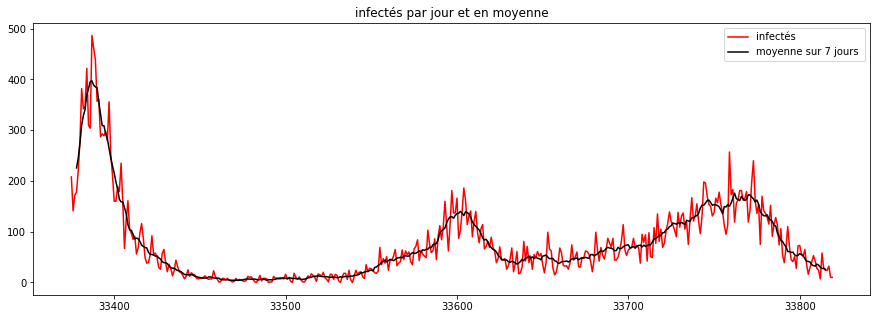

In [92]:
fig = plt.figure(figsize=(15,5))
plt.plot(df.index,df.incid_hosp + df.incid_rea, label="infectés", color="red")
plt.plot(df.index[3:len(df)-4], seven_day_avg, label = "moyenne sur 7 jours ", color="black")
plt.title("infectés par jour et en moyenne")
plt.legend()
plt.show()

on observe une courbe similaire au début à celle vu plus tot, on va essayer de construire une courbe similaire pour trouver les paramètres qu'on recherche

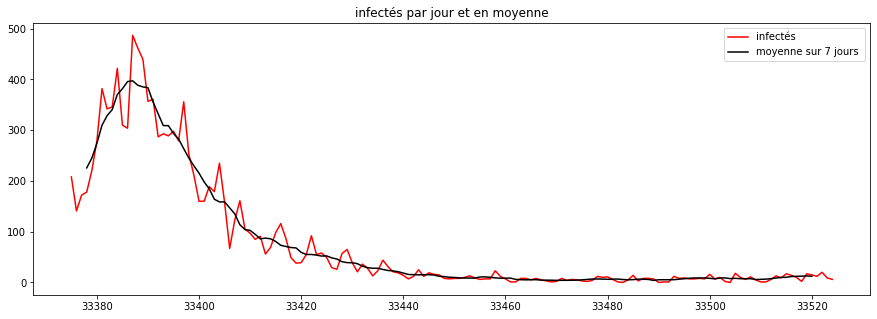

In [90]:
fig = plt.figure(figsize=(15,5))
plt.plot(df.index[:150],df.incid_hosp[:150] + df.incid_rea[:150], label="infectés", color="red")
plt.plot(df.index[3:150-4], seven_day_avg[:150-7], label = "moyenne sur 7 jours ", color="black")
plt.title("infectés par jour et en moyenne")
plt.legend()
plt.show()

In [82]:
i1 = 1/12000000 # pour être à lechelle de la France
s1 = 1-i1  
r1 = 0

gamma1 = 1/20
beta1 = 0.03

solution = solve_ivp(equadiff, [0, 143], [i1, s1, r1], method='RK45', args=(
    gamma1, beta1), max_step=0.01)

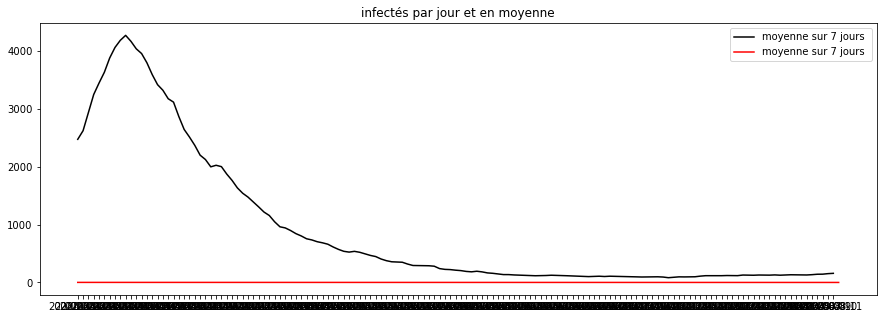

In [83]:
fig = plt.figure(figsize=(15,5))
plt.plot(df.index[3:150-4], seven_day_avg[:150-7], label = "moyenne sur 7 jours ", color="black")
plt.plot(solution.t, solution.y[0]*12000000, label = "moyenne sur 7 jours ", color="red")
plt.title("infectés par jour et en moyenne")
plt.legend()
plt.show()

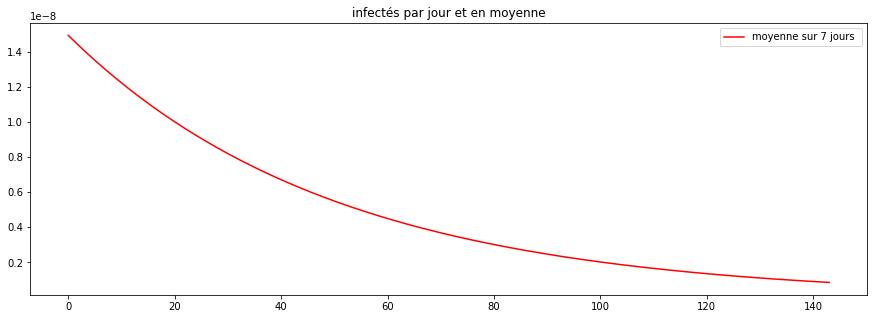

In [84]:
fig = plt.figure(figsize=(15,5))
plt.plot(solution.t, solution.y[0], label = "moyenne sur 7 jours ", color="red")
plt.title("infectés par jour et en moyenne")
plt.legend()
plt.show()